### We used Keras library to build Convolutional Neural Network (CNN) model that takes images as input and classify benign and malignant cancer types.
### Since the data is unbalanced we performed data augmentation and increased the size of minority class(here malignant) 
### Trained the model for 3 epochs on 24528 images.



In [2]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [2]:
'''Importing libraries'''

import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
import matplotlib.pyplot as plt
import h5py
import random
import os
import seaborn as sns
from PIL import Image

In [3]:
train_df = pd.read_csv('/Users/prathyusha/Desktop/pranathi/ADS/project/train.csv')
test_df = pd.read_csv('/Users/prathyusha/Desktop/pranathi/ADS/project/test.csv')
image_train_path = '/Users/prathyusha/Desktop/pranathi/ADS/project/jpeg/train/'

## Data Cleansing

Checking for Null values

In [4]:
print(pd.isnull(train_df).sum())
print(train_df.shape)

image_name                         0
patient_id                         0
sex                               65
age_approx                        68
anatom_site_general_challenge    527
diagnosis                          0
benign_malignant                   0
target                             0
dtype: int64
(33126, 8)


In [5]:
print(pd.isnull(test_df).sum())
print(test_df.shape)

image_name                         0
patient_id                         0
sex                                0
age_approx                         0
anatom_site_general_challenge    351
dtype: int64
(10982, 5)


Drop the duplicated rows

In [6]:
train_df = train_df.drop_duplicates()
print(train_df.shape)

(33126, 8)


In [7]:
test_df = test_df.drop_duplicates()
print(test_df.shape)

(10982, 5)


In [8]:
# Total number of images in the dataset(train+test)
print("Total images in Train set: ",train_df['image_name'].count())
print("Total images in Test set: ",test_df['image_name'].count())

Total images in Train set:  33126
Total images in Test set:  10982


In [9]:
columns = train_df.keys()
columns = list(columns)
print(columns)

['image_name', 'patient_id', 'sex', 'age_approx', 'anatom_site_general_challenge', 'diagnosis', 'benign_malignant', 'target']


### Reading the train csv file and splitting the malignant and benign data

In [10]:
malignant = train_df[train_df['benign_malignant'] == 'malignant']
benign = train_df[train_df['benign_malignant'] == 'benign']

In [11]:
malignant.shape

(584, 8)

In [12]:
malignant.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
91,ISIC_0149568,IP_0962375,female,55.0,upper extremity,melanoma,malignant,1
235,ISIC_0188432,IP_0135517,female,50.0,upper extremity,melanoma,malignant,1
314,ISIC_0207268,IP_7735373,male,55.0,torso,melanoma,malignant,1
399,ISIC_0232101,IP_8349964,male,65.0,torso,melanoma,malignant,1
459,ISIC_0247330,IP_3232631,female,65.0,lower extremity,melanoma,malignant,1


In [13]:
benign.shape

(32542, 8)

## Checking for unique patient id's

In [14]:
print(f"The total patient ids are {train_df['patient_id'].count()}, from those the unique ids are {train_df['patient_id'].value_counts().shape[0]} ")

The total patient ids are 33126, from those the unique ids are 2056 


 The number of unique patients is less than the total number of patients. This means that, patients have multiple records.


Target distribution
0    32542
1      584
Name: target, dtype: int64


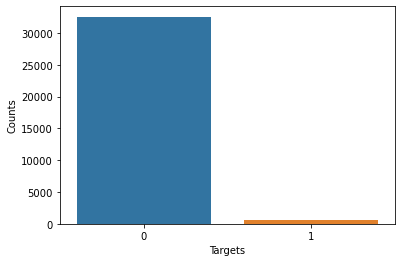

In [15]:
target_counts = train_df.target.value_counts()
print()
print("Target distribution")
print(target_counts)
sns.barplot(x=target_counts.index, y=target_counts.values)
plt.xlabel("Targets")
plt.ylabel("Counts")
plt.show()


We can see that our data is unbalanced

Sex distribution
male      17080
female    15981
Name: sex, dtype: int64


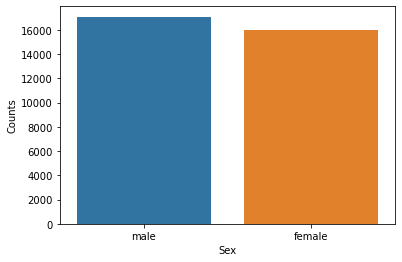

In [16]:
# Lets check sex distribution
sex_counts = train_df.sex.value_counts()
print("Sex distribution")
print(sex_counts)
sns.barplot(x=sex_counts.index, y=sex_counts.values)
plt.xlabel("Sex")
plt.ylabel("Counts")
plt.show()

Anatom Site distribution
torso              16845
lower extremity     8417
upper extremity     4983
head/neck           1855
palms/soles          375
oral/genital         124
Name: anatom_site_general_challenge, dtype: int64


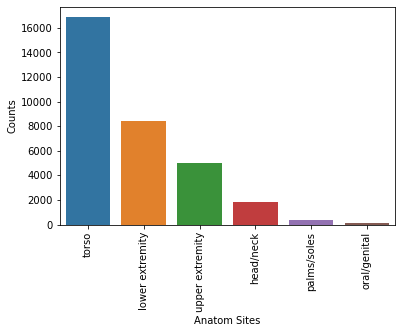

In [17]:
# Anatom Site
# Lets check sex distribution
anatom_site_counts = train_df.anatom_site_general_challenge.value_counts()
print("Anatom Site distribution")
print(anatom_site_counts)
sns.barplot(x=anatom_site_counts.index, y=anatom_site_counts.values)
plt.xticks(rotation=90)
plt.xlabel("Anatom Sites")
plt.ylabel("Counts")
plt.show()

Diagnosis distribution
unknown                               27124
nevus                                  5193
melanoma                                584
seborrheic keratosis                    135
lentigo NOS                              44
lichenoid keratosis                      37
solar lentigo                             7
cafe-au-lait macule                       1
atypical melanocytic proliferation        1
Name: diagnosis, dtype: int64


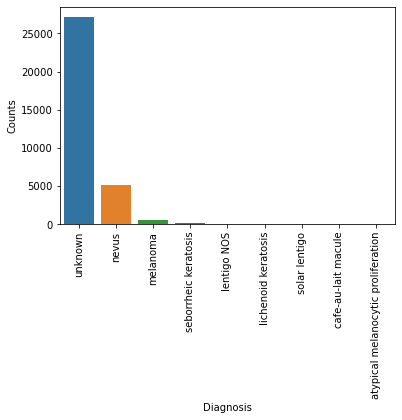

In [39]:
# Diagnosis
# Lets check Diagnosis distribution
diagnosis_counts = train_df.diagnosis.value_counts()
print("Diagnosis distribution")
print(diagnosis_counts)
sns.barplot(x=diagnosis_counts.index, y=diagnosis_counts.values)
plt.xticks(rotation=90)
plt.xlabel("Diagnosis")
plt.ylabel("Counts")
plt.show()

### Density Plot for Ages w.r.t Target

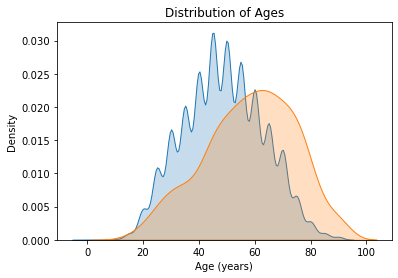

In [18]:
sns.kdeplot(train_df.loc[train_df['target'] == 0, 'age_approx'], label = 'Benign',shade=True)

# KDE plot of age that were diagnosed as malignant
sns.kdeplot(train_df.loc[train_df['target'] == 1, 'age_approx'], label = 'Malignant',shade=True)

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

Patient Overlap : 
Checking if same patients exist in train and test data sets.

In [19]:
ids_train = train_df.patient_id.values
# Extract patient id's for the validation set
ids_test = test_df.patient_id.values

# Create a "set" datastructure of the training set id's to identify unique id's
ids_train_set = set(ids_train)
print(f'There are {len(ids_train_set)} unique Patient IDs in the training set')
# Create a "set" datastructure of the validation set id's to identify unique id's
ids_test_set = set(ids_test)
print(f'There are {len(ids_test_set)} unique Patient IDs in the test set')

# Identify patient overlap by looking at the intersection between the sets
patient_overlap = list(ids_train_set.intersection(ids_test_set))
n_overlap = len(patient_overlap)
print(f'There are {n_overlap} Patient IDs in both the training and test sets')

There are 2056 unique Patient IDs in the training set
There are 690 unique Patient IDs in the test set
There are 0 Patient IDs in both the training and test sets


# Sample images

Samples with Melanoma


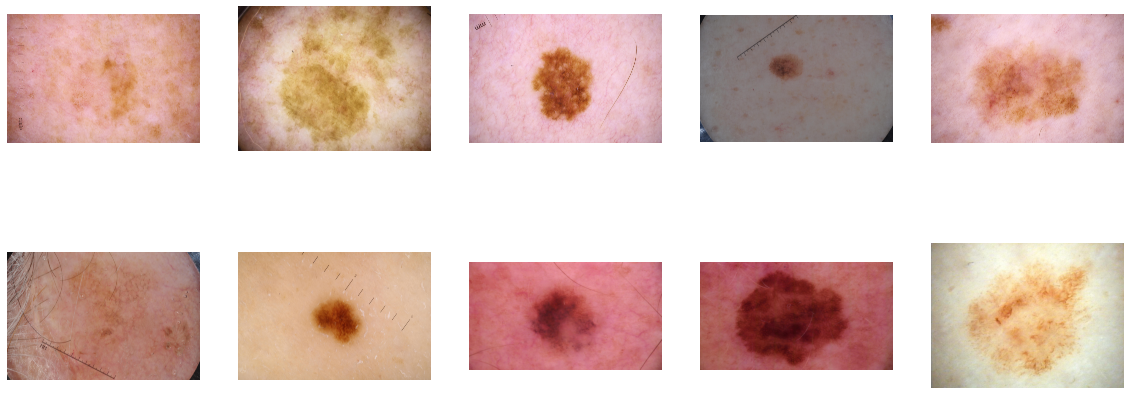

Samples without Melanoma


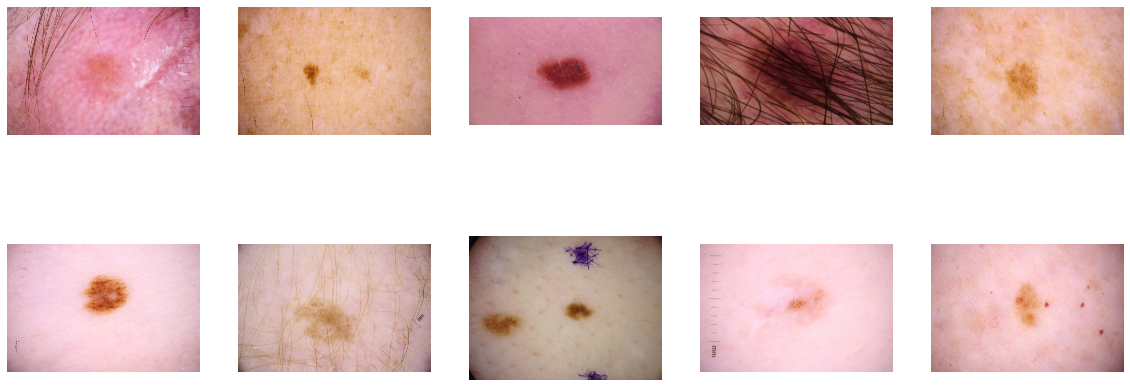

In [20]:
# Lets look at some images
print("Samples with Melanoma")
imgs = train_df[train_df.target==1]['image_name'].values
_, axs = plt.subplots(2, 5, figsize=(20, 8))
axs = axs.flatten()
for f_name,ax in zip(imgs[:10],axs):
    img = Image.open(f"{image_train_path}{f_name}.jpg")
    ax.imshow(img)
    ax.axis('off')
plt.show()

print("Samples without Melanoma")
imgs = train_df[train_df.target==0]['image_name'].values
_, axs = plt.subplots(2, 5, figsize=(20, 8))
axs = axs.flatten()
for f_name,ax in zip(imgs[:10],axs):
    img = Image.open(f"{image_train_path}{f_name}.jpg")
    ax.imshow(img)
    ax.axis('off')    
plt.show()

In [21]:
train_df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [81]:
'''Taking the malignant data frame which consists the malignant data and taking the image_name/id from it'''
'''Checking whether all the corresponding malignant images from the jpeg/train folder exists'''
'''Copying and renaming all the malignant images to another folder'''

import os.path
from os import path

malignant_img = malignant['image_name'].values

count = 0

for i in malignant_img:
    imgs =  i + '.jpg'
    mal_img = image_train_path + imgs
    #print(mal_img)
    
    if os.path.exists(image_train_path + imgs): 
        #print("exits")
        my_dest = "malignant" + str(count) + ".jpg"
        my_source = mal_img
        my_dest = "/Users/prathyusha/Desktop/pranathi/ADS/project/train/" + my_dest
        
        os.rename(my_source,my_dest)
        count +=1
        
    else:
        print("nope")

In [82]:
'''Taking the benign data frame which consists the benign data and taking the image_name/id from it'''
'''Checking whether all the corresponding benign images from the jpeg/train folder exists'''
'''Copying and renaming all the benign images to another folder'''

import os.path
from os import path

benign_img = benign['image_name'].values

count = 0

for i in benign_img:
    imgs =  i + '.jpg'
    b_img = image_train_path + imgs

    if os.path.exists(image_train_path + imgs):
        
        my_dest = "benign" + str(count) + ".jpg"
        my_source = b_img
        my_dest = "/Users/prathyusha/Desktop/pranathi/ADS/project/train/" + my_dest
        
        os.rename(my_source,my_dest)
        count +=1

In [22]:
'''Defining constants'''

FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [24]:
train_df.head(5)

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [25]:
import cv2
from skimage import io 
from skimage.transform import rotate, AffineTransform, warp
import random
from skimage import img_as_ubyte
from skimage.util import random_noise

In [26]:

#Lets define functions for each operation
def anticlockwise_rotation(image):
    angle= random.randint(0,180)
    return rotate(image, angle)

def clockwise_rotation(image):
    angle= random.randint(0,180)
    return rotate(image, -angle)

def h_flip(image):
    return  np.fliplr(image)

def v_flip(image):
    return np.flipud(image)

def add_noise(image):
    return random_noise(image)

def blur_image(image):
    return cv2.GaussianBlur(image, (9,9),0)

#I would not recommend warp_shifting, because it distorts image, but can be used in many use case like 
#classifying blur and non-blur images
def warp_shift(image): 
    transform = AffineTransform(translation=(0,40))  #chose x,y values according to your convinience
    warp_image = warp(image, transform, mode="wrap")
    return warp_image

In [120]:
transformations = {'rotate anticlockwise': anticlockwise_rotation,
                      'rotate clockwise': clockwise_rotation,
                      'horizontal flip': h_flip, 
                      'vertical flip': v_flip,
                   'warp shift': warp_shift,
                   'adding noise': add_noise,
                   'blurring image':blur_image
                 }                #use dictionary to store names of functions 

images_path="/Users/prathyusha/Desktop/pranathi/ADS/project/train" #path to original images
augmented_path="/Users/prathyusha/Desktop/pranathi/ADS/project/train" # path to store aumented images
images=[] # to store paths of images from folder

for im in os.listdir(images_path):  # read image name from folder and append its path into "images" array 
    if im.find("malignant")!=-1:
        images.append(os.path.join(images_path,im))

images_to_generate=5000  #you can change this value according to your requirement
i=1                        # variable to iterate till images_to_generate

while i<=images_to_generate:    
    image=random.choice(images)
    original_image = io.imread(image)
    transformed_image=None
#     print(i)
    n = 0       #variable to iterate till number of transformation to apply
    transformation_count = random.randint(1, len(transformations)) #choose random number of transformation to apply on the image
    
    while n <= transformation_count:
        key = random.choice(list(transformations)) #randomly choosing method to call
        transformed_image = transformations[key](original_image)
        n = n + 1
        
    new_image_path= "%s/augmented_image_%s.jpg" %(augmented_path, i)
    transformed_image = img_as_ubyte(transformed_image)  #Convert an image to unsigned byte format, with values in [0, 255].
    transformed_image=cv2.cvtColor(transformed_image, cv2.COLOR_BGR2RGB) #convert image to RGB before saving it
    cv2.imwrite(new_image_path, transformed_image) # save transformed image to path
    i =i+1
#to generate more images, put above 3 statement inside while n<... loop

In [27]:
'''Prepare training data'''

filenames = os.listdir("/Users/prathyusha/Desktop/pranathi/ADS/project/train/")
categories = []
for filename in filenames:
    
    if 'benign' in filename:
        categories.append(0)
    else:
        categories.append(1)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

<AxesSubplot:>

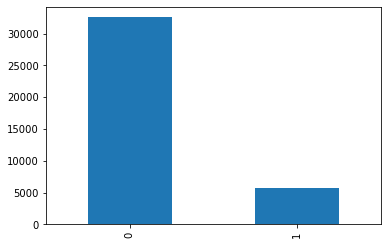

In [28]:
'''Total count of malignant and benign data'''

df['category'].value_counts().plot.bar()

In [29]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid')) 

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

In [30]:
'''Prevent from over fitting we will stop the learning after 10 epochs'''

earlystop = EarlyStopping(patience=10)

In [31]:
'''Reduces the learning rate when then accuracy not increase for 2 steps'''

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [32]:
callbacks = [earlystop, learning_rate_reduction]

In [33]:
'''Imagenerator will convert it one-hot encoding and we will convert 1 to malignant and 0 to benign'''

df["category"] = df["category"].replace({0: 'benign', 1: 'malignant'})

In [107]:
train, test_df = train_test_split(df,stratify=df["category"], test_size=0.20, random_state=42)
train = train.reset_index(drop=True)
test_df = test_df.reset_index(drop=True) 

print(train.shape)
print(test_df.shape)


(30661, 2)
(7666, 2)


In [35]:
'''Splits the train data into train(80%) and validation(20%)'''
train_df, validate_df = train_test_split(train,stratify=train["category"], test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [36]:
train_df.shape

(24528, 2)

In [37]:
validate_df.shape

(6133, 2)

<AxesSubplot:>

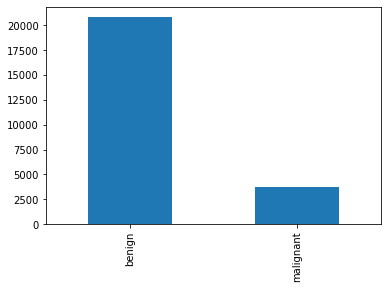

In [38]:
'''Shows the number of records for each category in the train data'''

train_df['category'].value_counts().plot.bar()

<AxesSubplot:>

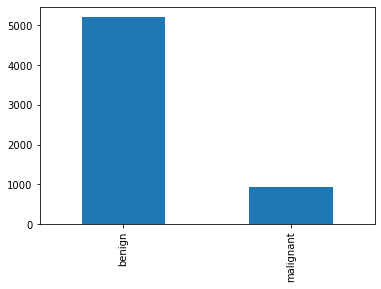

In [39]:
'''Shows the number of records for each category in the validation data'''

validate_df['category'].value_counts().plot.bar()

In [40]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [41]:
train_df['category'].value_counts()

benign       20826
malignant     3702
Name: category, dtype: int64

In [42]:
'''Rescale and reshape the images in the training dataset'''

train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "/Users/prathyusha/Desktop/pranathi/ADS/project/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=batch_size
)

Found 24527 validated image filenames belonging to 2 classes.


/Users/prathyusha/opt/anaconda3/lib/python3.8/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


In [43]:
'''Rescale and reshape the images in the validation dataset'''

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "/Users/prathyusha/Desktop/pranathi/ADS/project/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=batch_size
)

Found 6133 validated image filenames belonging to 2 classes.


In [44]:
class_weight = {0: 0.58,
                1: 3.31}

In [182]:
'''Fitting the model'''

#epochs=3 if FAST_RUN else 5
epochs=3
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks, class_weight=class_weight
)


Epoch 1/3
1635/1635 [==============================] - 5584s 3s/step - loss: 0.4744 - accuracy: 0.7295 - val_loss: 0.4162 - val_accuracy: 0.7621
Epoch 2/3
1635/1635 [==============================] - 5973s 4s/step - loss: 0.4338 - accuracy: 0.7552 - val_loss: 0.3723 - val_accuracy: 0.7910
Epoch 3/3
1635/1635 [==============================] - 46761s 29s/step - loss: 0.4206 - accuracy: 0.7639 - val_loss: 0.2983 - val_accuracy: 0.8449


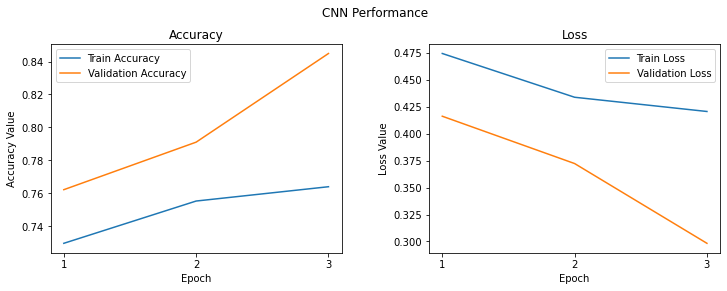

In [7]:
'Performance Visualization'
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,4))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1,4,1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1,4,1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [183]:
'''Saving the model'''

model.save_weights("model1.h7")

In [184]:
'''Listing out the test files'''

test_filenames = os.listdir("/Users/prathyusha/Desktop/pranathi/ADS/project/jpeg/test/")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [45]:
test_df.shape

(7666, 2)

In [108]:
test_df.head()

,filename,category
0,benign5332.jpg,benign
1,benign2937.jpg,benign
2,augmented_image_1190.jpg,malignant
3,malignant43.jpg,malignant
4,benign14363.jpg,benign


In [48]:
'''Rescaling and reshaping the test images'''

test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "/Users/prathyusha/Desktop/pranathi/ADS/project/train/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 7666 validated image filenames.


In [50]:
nb_samples = test_df.shape[0]

In [52]:
model.load_weights("/Users/prathyusha/Desktop/pranathi/ADS/project/model1.h7")

In [ ]:
from tensorflow.keras.models import load_model
new_model = load_model('/Users/prathyusha/Desktop/pranathi/ADS/project/model1.h7.data-00000-of-00001')

In [53]:
'''Predicting the test images'''

predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

In [54]:
predict.shape

(7666, 1)

In [64]:
predict

array([[0.00737825],
       [0.02539134],
       [0.859887  ],
       ...,
       [0.00266126],
       [0.9958929 ],
       [0.9955868 ]], dtype=float32)

In [97]:
'''Creating a dataframe pred_df '''
pred_df = pd.DataFrame({'image_name': test_df['filename'], 'target': np.concatenate(predict)})
#pred_df.to_csv('submission_vgg.csv',header=True, index=False)
pred_df.head(10)
print(pred_df[(pred_df['target']>0.5) & (pred_df['image_name'].str.contains("malignant"))])

            image_name    target
3      malignant43.jpg  0.783658
48    malignant214.jpg  0.669000
67    malignant145.jpg  0.750054
145   malignant438.jpg  0.502996
186   malignant180.jpg  0.652000
...                ...       ...
7116  malignant525.jpg  0.594205
7243  malignant518.jpg  0.956544
7302   malignant82.jpg  0.576730
7401   malignant10.jpg  0.646077
7508  malignant101.jpg  0.531521

[78 rows x 2 columns]


In [83]:
print(pred_df[pred_df['image_name'].str.contains("malignant")])

            image_name    target
3      malignant43.jpg  0.783658
19    malignant309.jpg  0.204460
48    malignant214.jpg  0.669000
67    malignant145.jpg  0.750054
127   malignant472.jpg  0.247486
...                ...       ...
7302   malignant82.jpg  0.576730
7364  malignant244.jpg  0.323003
7390   malignant94.jpg  0.203134
7401   malignant10.jpg  0.646077
7508  malignant101.jpg  0.531521

[131 rows x 2 columns]


In [104]:
'Rounding target to nearest integer'
pred_df['RoundedTarget']=pred_df['target'].round(0)
print(pred_df.head())

                 image_name    target  RoundedTarget
0            benign5332.jpg  0.007378            0.0
1            benign2937.jpg  0.025391            0.0
2  augmented_image_1190.jpg  0.859887            1.0
3           malignant43.jpg  0.783658            1.0
4           benign14363.jpg  0.001213            0.0


In [109]:
test_df.head()
#new_df=test_df

,filename,category
0,benign5332.jpg,benign
1,benign2937.jpg,benign
2,augmented_image_1190.jpg,malignant
3,malignant43.jpg,malignant
4,benign14363.jpg,benign


In [110]:
test_df['Target'] = test_df['category'].apply(lambda x: 1 if x =='malignant' else 0)

In [111]:
test_df

,filename,category,Target
0,benign5332.jpg,benign,0
1,benign2937.jpg,benign,0
2,augmented_image_1190.jpg,malignant,1
3,malignant43.jpg,malignant,1
4,benign14363.jpg,benign,0
...,...,...,...
7661,benign19504.jpg,benign,0
7662,augmented_image_3227.jpg,malignant,1
7663,benign27828.jpg,benign,0
7664,augmented_image_1712.jpg,malignant,1


In [114]:
'''Confusion Matrix'''
from sklearn.metrics import confusion_matrix
confusion_matrix(test_df['Target'],pred_df['RoundedTarget'])

array([[5474, 1035],
       [ 259,  898]])

In [115]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

<AxesSubplot:>

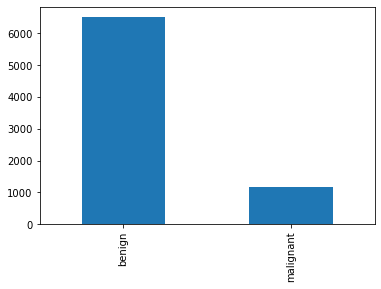

In [116]:
test_df['category'].value_counts().plot.bar()

In [117]:
test_df.head()

,filename,category,Target
0,benign5332.jpg,benign,0
1,benign2937.jpg,benign,0
2,augmented_image_1190.jpg,malignant,1
3,malignant43.jpg,malignant,1
4,benign14363.jpg,benign,0
